## Phase 1: Introduction & Environment Setup

This phase covers importing the necessary libraries, setting up the environment, and loading the dataset.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (recall_score, f1_score, precision_score, precision_recall_curve, 
                              brier_score_loss, roc_auc_score, average_precision_score, 
                              confusion_matrix, classification_report, accuracy_score, make_scorer)
import xgboost as xgb
import pandas as pd

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

The dataset comes pre-split into an 80% training file (`churn-bigml-80.csv`) and a 20% testing file (`churn-bigml-20.csv`). However, we are recombining them into a single dataset and applying our own split for several important reasons:

1. **Stratification:** Churn datasets are highly imbalanced so we need to guarantee that both our training and testing sets have the exact same proportion of churners. Recombining allows us to use `stratify=y` during our split.
2. **Global Data Quality Checks:** It is safer to check for and remove exact duplicate rows across the *entire* dataset before splitting, preventing identical records from appearing in both the train and test sets (which causes data leakage).
3. **Randomization:** Recombining and splitting with a known `RANDOM_STATE` ensures the data is thoroughly shuffled and reproducible, removing any hidden ordering bias that might exist in the original files.

In [2]:
# Load and combine the datasets
file1_path = 'data/churn-bigml-80.csv'
file2_path = 'data/churn-bigml-20.csv'

# Read both files
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

print(f"File 1 shape: {df1.shape}")
print(f"File 2 shape: {df2.shape}")

# Combine datasets
df_full = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"\nCombined dataset shape: {df_full.shape}")
print(f"Total records: {df_full.shape[0]:,}")
print(f"Number of features: {df_full.shape[1] - 1}")  # Excluding target column

File 1 shape: (2666, 20)
File 2 shape: (667, 20)

Combined dataset shape: (3333, 20)
Total records: 3,333
Number of features: 19


## Phase 2: Exploratory Data Analysis (EDA)

In [3]:
# Quick look at the data
print("\nFirst few rows:")
print("=" * 50)
df_full.head()


First few rows:


State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25             265.10              110   
1                     26             161.60              123   
2                      0             243.40              114   
3                      0             299.40               71   
4                      0             166.70              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07             197.40               99             16.78   
1             27.47             195.50              103             16.62   
2             41.38             121.20              110             10.30   
3             50.90              61.90               88              5.26   
4             28.34             148.30              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0               244.70                 91               11.01   
1               254.40                103               11.45   
2               162.60                104                7.32   
3               196.90                 89                8.86   
4               186.90                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0               10.00                 3               2.70   
1               13.70                 3               3.70   
2               12.20                 5               3.29   
3                6.60                 7               1.78   
4               10.10                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

Let's examine the data types and the range of values for each feature to understand the scale of our data and identify which features need scaling or encoding later in the preprocessing phase.

In [4]:
# Examine data types and scales
print("Data Types and Sample Values:")
print("=" * 50)

# Get info about each column
for col in df_full.columns:
    dtype = df_full[col].dtype
    unique_count = df_full[col].nunique()
    
    if dtype in ['int64', 'float64']:
        min_val = df_full[col].min()
        max_val = df_full[col].max()
        mean_val = df_full[col].mean()
        print(f"{col:30} | {str(dtype):8} | Range: [{min_val:>10.2f}, {max_val:>10.2f}] | Mean: {mean_val:>10.2f}")
    else:
        sample_values = df_full[col].unique()[:3]
        print(f"{col:30} | {str(dtype):8} | Unique: {unique_count:>4} | Sample: {list(sample_values)}")

Data Types and Sample Values:
State                          | object   | Unique:   51 | Sample: ['KS', 'OH', 'NJ']
Account length                 | int64    | Range: [      1.00,     243.00] | Mean:     101.06
Area code                      | int64    | Range: [    408.00,     510.00] | Mean:     437.18
International plan             | object   | Unique:    2 | Sample: ['No', 'Yes']
Voice mail plan                | object   | Unique:    2 | Sample: ['Yes', 'No']
Number vmail messages          | int64    | Range: [      0.00,      51.00] | Mean:       8.10
Total day minutes              | float64  | Range: [      0.00,     350.80] | Mean:     179.78
Total day calls                | int64    | Range: [      0.00,     165.00] | Mean:     100.44
Total day charge               | float64  | Range: [      0.00,      59.64] | Mean:      30.56
Total eve minutes              | float64  | Range: [      0.00,     363.70] | Mean:     200.98
Total eve calls                | int64    | Range: [     

### Duplicate Check

Let's check for and remove any duplicate records in the dataset.

In [5]:
# Check for duplicates
duplicates = df_full.duplicated().sum()

print(duplicates)

0


### Missing Values Check

Let's check if there are any missing values in the dataset that need to be handled before modeling.

In [6]:
# Check for missing values
missing_values = df_full.isnull().sum()
total_missing = missing_values.sum()

print(missing_values)
print(total_missing)

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64
0


In [7]:
# Check churn distribution in full dataset
churn_summary = pd.DataFrame({
    'Count': df_full['Churn'].value_counts(),
    'Percentage (%)': df_full['Churn'].value_counts(normalize=True) * 100
}).round(2)

churn_summary.index = ['No Churn (False)', 'Churn (True)']
churn_summary.index.name = 'Status'

# Display the dataframe
display(churn_summary)

print(f"\nTotal records: {len(df_full):,}")
print(f"Overall Churn Rate: {churn_summary.loc['Churn (True)', 'Percentage (%)']}%")

Count  Percentage (%)
Status                                 
No Churn (False)   2850           85.51
Churn (True)        483           14.49


Total records: 3,333
Overall Churn Rate: 14.49%


### Train/Test Split

We assume that the churn rate in the future will be similar to the historical churn rate (~15%). 

Because our churn rate is relatively low (an imbalanced dataset), we use stratified sampling. This ensures that the minority class (churners) is adequately captured and represented in both the training and testing splits, maintaining the exact same proportion of churners across both sets.

Now that we've verified data quality, we'll split the data.

In [8]:
# Perform train/test split with stratification

X = df_full.drop('Churn', axis=1)
y = df_full['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df_full)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df_full)*100:.1f}%)")

Training set: 2,666 samples (80.0%)
Test set: 667 samples (20.0%)


---

### Visualizing Features and Relationships

Now that the data is loaded, cleaned, and split, we perform EDA to find patterns:
- Analyze the training data to understand feature distributions
- Create visualizations to understand feature relationships with Churn
- Identify key indicators of churn
- Examine correlations and multicollinearity

Note that we only use the training data (`X_train`, `y_train`) for EDA to avoid data leakage.

### Target Variable Distribution

Let's visualize the distribution of the target variable to understand the baseline churn rate.

In [9]:
# Combine training features and target for easier plotting
train_df = X_train.copy()
train_df['Churn'] = y_train.values

print(f"Training DataFrame created with shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

Training DataFrame created with shape: (2666, 20)
Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']


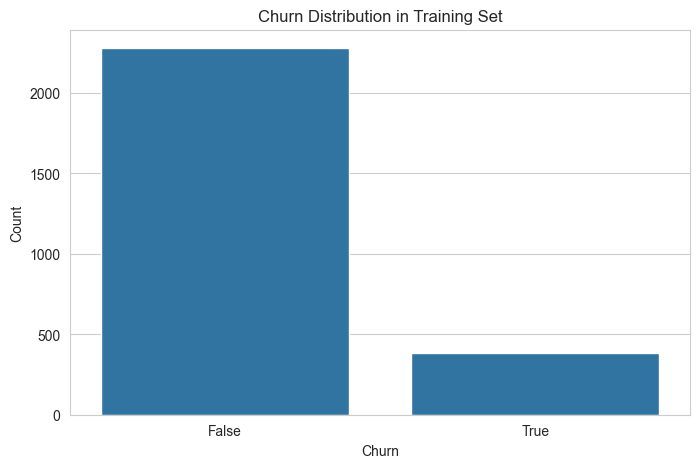

In [10]:
# Simple churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title('Churn Distribution in Training Set')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.savefig('images/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Categorical Feature Relationships

Let's visualize the distributions of categorical features to see how they relate to churn.

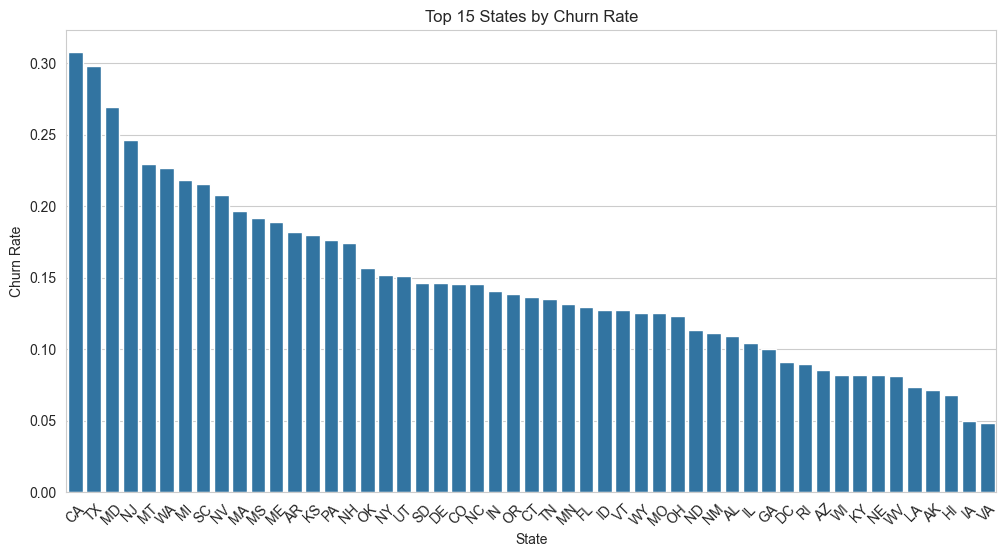

In [11]:
# State vs Churn
state_churn = train_df.groupby('State')['Churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=state_churn.index, y=state_churn.values)
plt.title('Top 15 States by Churn Rate')
plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.savefig('images/state_churn_rate.png', dpi=300, bbox_inches='tight')
plt.show()

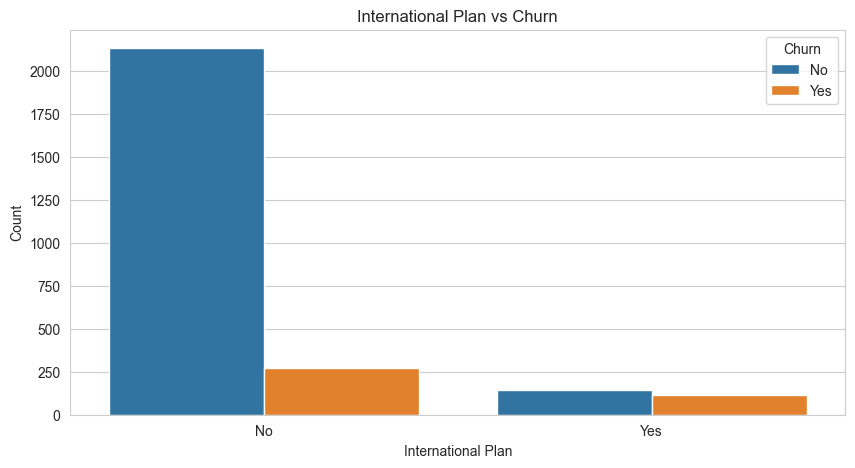

In [12]:
# International Plan vs Churn
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='International plan', hue='Churn')
plt.title('International Plan vs Churn')
plt.xlabel('International Plan')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.savefig('images/international_plan_churn.png', dpi=300, bbox_inches='tight')
plt.show()

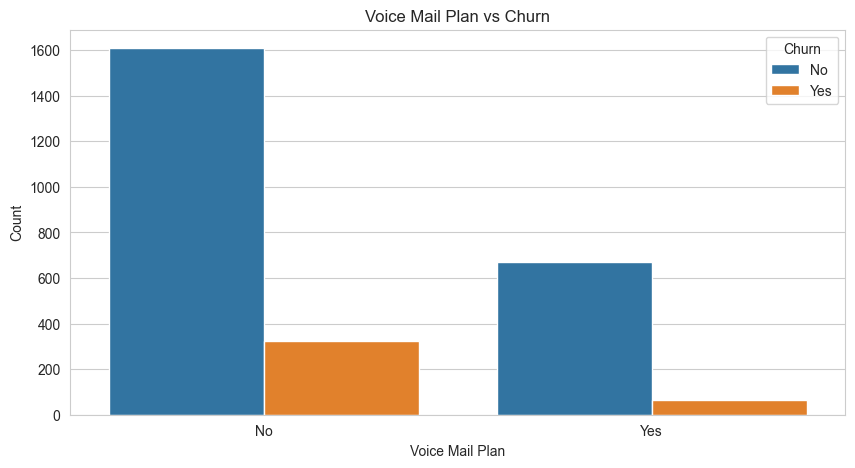

In [13]:
# Voice Mail Plan vs Churn
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='Voice mail plan', hue='Churn')
plt.title('Voice Mail Plan vs Churn')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.savefig('images/voicemail_plan_churn.png', dpi=300, bbox_inches='tight')
plt.show()

**Key Insights from Categorical Features:**
- **International Plan:** There is a very high churn rate among customers with an international plan. In fact, nearly half of the customers who have an international plan end up churning.
- **Voice Mail Plan:** Having a voice mail plan does not seem to be a strong indicator of churn, as the proportion of churners is relatively similar whether they have the plan or not.

### Numeric Feature Relationships

Let's explore how numeric features like minutes and calls relate to churn.

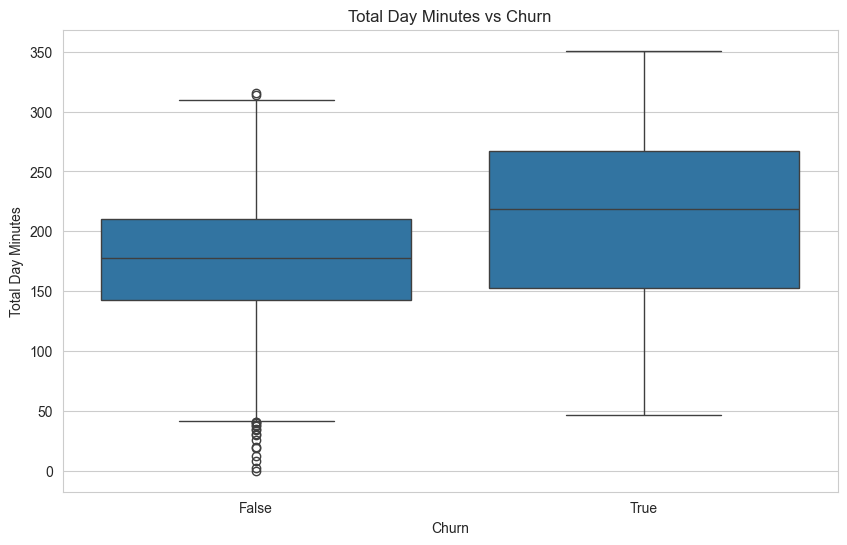

In [14]:
# Total Day Minutes vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Churn', y='Total day minutes')
plt.title('Total Day Minutes vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Day Minutes')
plt.savefig('images/total_day_minutes_churn.png', dpi=300, bbox_inches='tight')
plt.show()

**Key Insights from Numeric Features:**
- **Total Day Minutes:** The box plot shows that customers who churn tend to have significantly higher total day minutes compared to those who do not churn. This suggests that high usage during the day might be a strong predictor of churn.

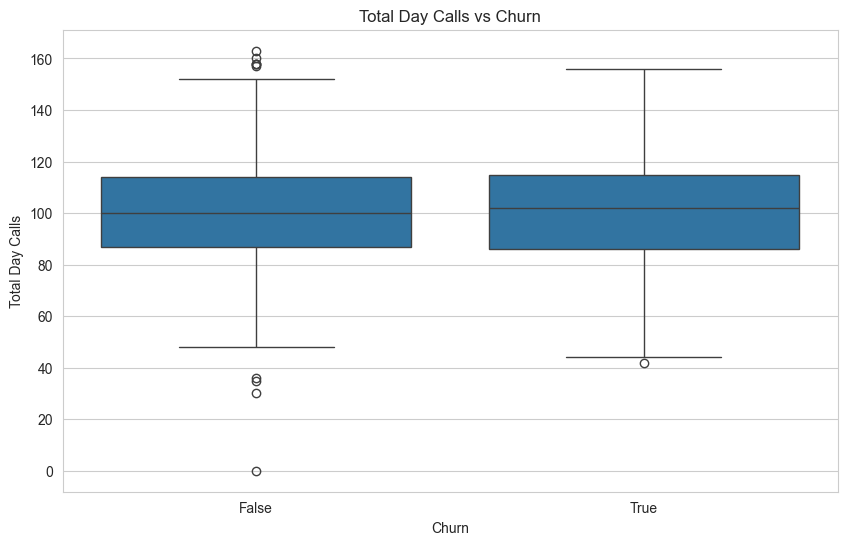

In [15]:
# Total Day Calls vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Churn', y='Total day calls')
plt.title('Total Day Calls vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Day Calls')
plt.savefig('images/total_day_calls_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

We want to avoid multicollinearity issues in linear models and simplify the feature space for tree-based models.

Let's calculate and visualize the correlation matrix for all numeric features to identify strong relationships and potential redundancies.

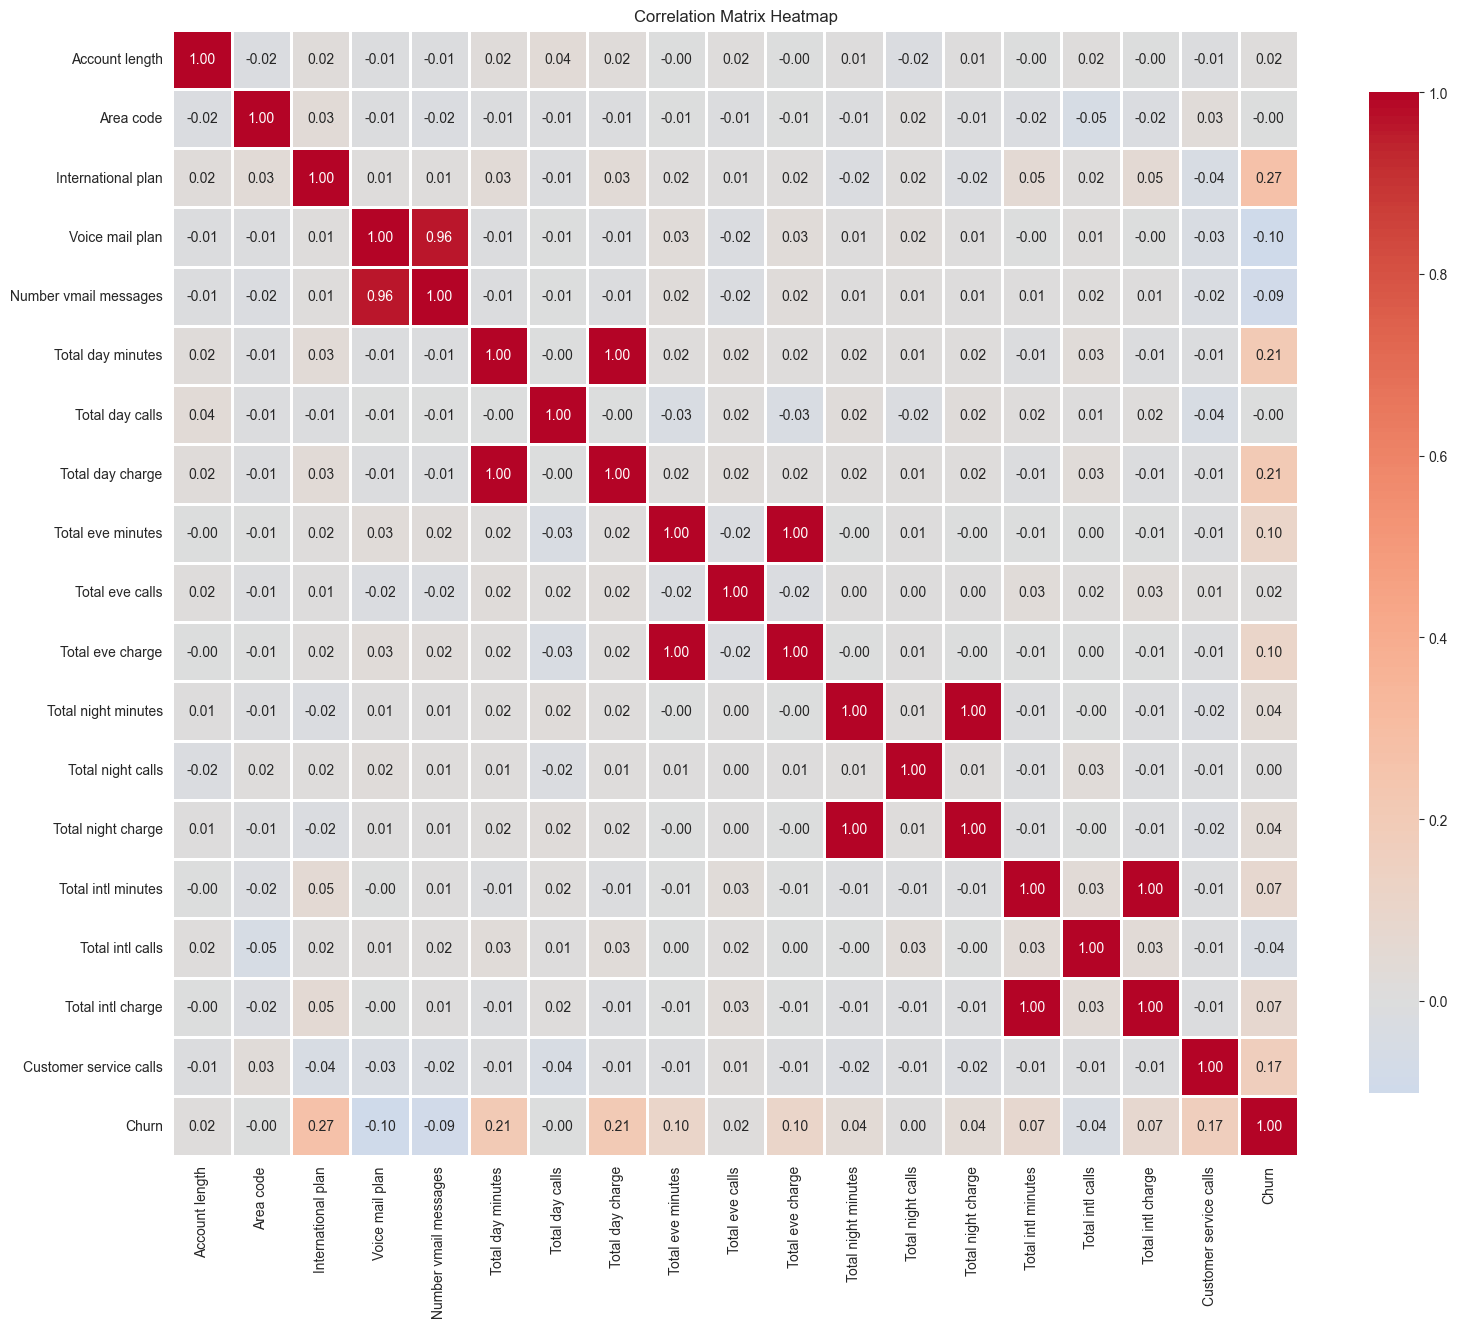

In [16]:
# Create numeric version of train_df for correlation analysis
train_df_numeric = train_df.copy()
train_df_numeric['Churn'] = train_df_numeric['Churn'].astype(int)
train_df_numeric['International plan'] = (train_df_numeric['International plan'] == 'Yes').astype(int)
train_df_numeric['Voice mail plan'] = (train_df_numeric['Voice mail plan'] == 'Yes').astype(int)

# Select only numeric columns for correlation analysis
train_df_numeric = train_df_numeric.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = train_df_numeric.corr()

# Visualize the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Get correlations with Churn and sort by absolute value
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Features most correlated with Churn:")
print(churn_correlations)

Features most correlated with Churn:
Churn                     1.00
International plan        0.27
Total day minutes         0.21
Total day charge          0.21
Customer service calls    0.17
Total eve minutes         0.10
Total eve charge          0.10
Total intl charge         0.07
Total intl minutes        0.07
Total night charge        0.04
Total night minutes       0.04
Total eve calls           0.02
Account length            0.02
Total night calls         0.00
Area code                -0.00
Total day calls          -0.00
Total intl calls         -0.04
Number vmail messages    -0.09
Voice mail plan          -0.10
Name: Churn, dtype: float64


In [18]:
# Find highly correlated feature pairs (other than with Churn)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")


Highly correlated feature pairs (|r| > 0.8):
Voice mail plan <-> Number vmail messages: 0.958
Total day minutes <-> Total day charge: 1.000
Total eve minutes <-> Total eve charge: 1.000
Total night minutes <-> Total night charge: 1.000
Total intl minutes <-> Total intl charge: 1.000


In [19]:
# Remove multicollinear features
features_to_remove = ['Total day charge', 'Total eve charge', 'Total night charge', 
                      'Total intl charge', 'Voice mail plan']

print(f"Removing {len(features_to_remove)} features to address multicollinearity:")
for feature in features_to_remove:
    print(f"  - {feature}")

# Create cleaned dataframe
train_df_clean = train_df.copy()
train_df_numeric_clean = train_df_numeric.drop(columns=features_to_remove)

print(f"\nOriginal features: {train_df_numeric.shape[1]}")
print(f"After removing multicollinear features: {train_df_numeric_clean.shape[1]}")
print(f"Features removed: {len(features_to_remove)}")

Removing 5 features to address multicollinearity:
  - Total day charge
  - Total eve charge
  - Total night charge
  - Total intl charge
  - Voice mail plan

Original features: 19
After removing multicollinear features: 14
Features removed: 5


### Addressing Multicollinearity

The correlation analysis revealed perfect multicollinearity (correlation = 1.00) between the 'minutes' and 'charge' features for day, evening, night, and international usage. This is expected since charges are calculated directly from minutes.

Additionally, Voice mail plan and Number vmail messages have a very high correlation (0.96). If a customer has voicemail messages, we know they have a voicemail plan, making the plan variable redundant.

**Why this matters:**
- **Logistic Regression:** Highly sensitive to multicollinearity. It causes the model's coefficients (weights) to become unstable and wildly inflated, ruining the interpretability of feature importance and potentially degrading performance.
- **Tree-Based Ensembles (Random Forest, XGBoost):** While tree models are generally robust to multicollinearity in terms of predictive performance, having highly correlated features splits the "feature importance" between them. This makes it difficult to determine which features are actually driving the model's decisions.

Removing these redundant features will eliminate multicollinearity issues, improving model stability for linear models and ensuring accurate feature importance rankings for our tree-based models.

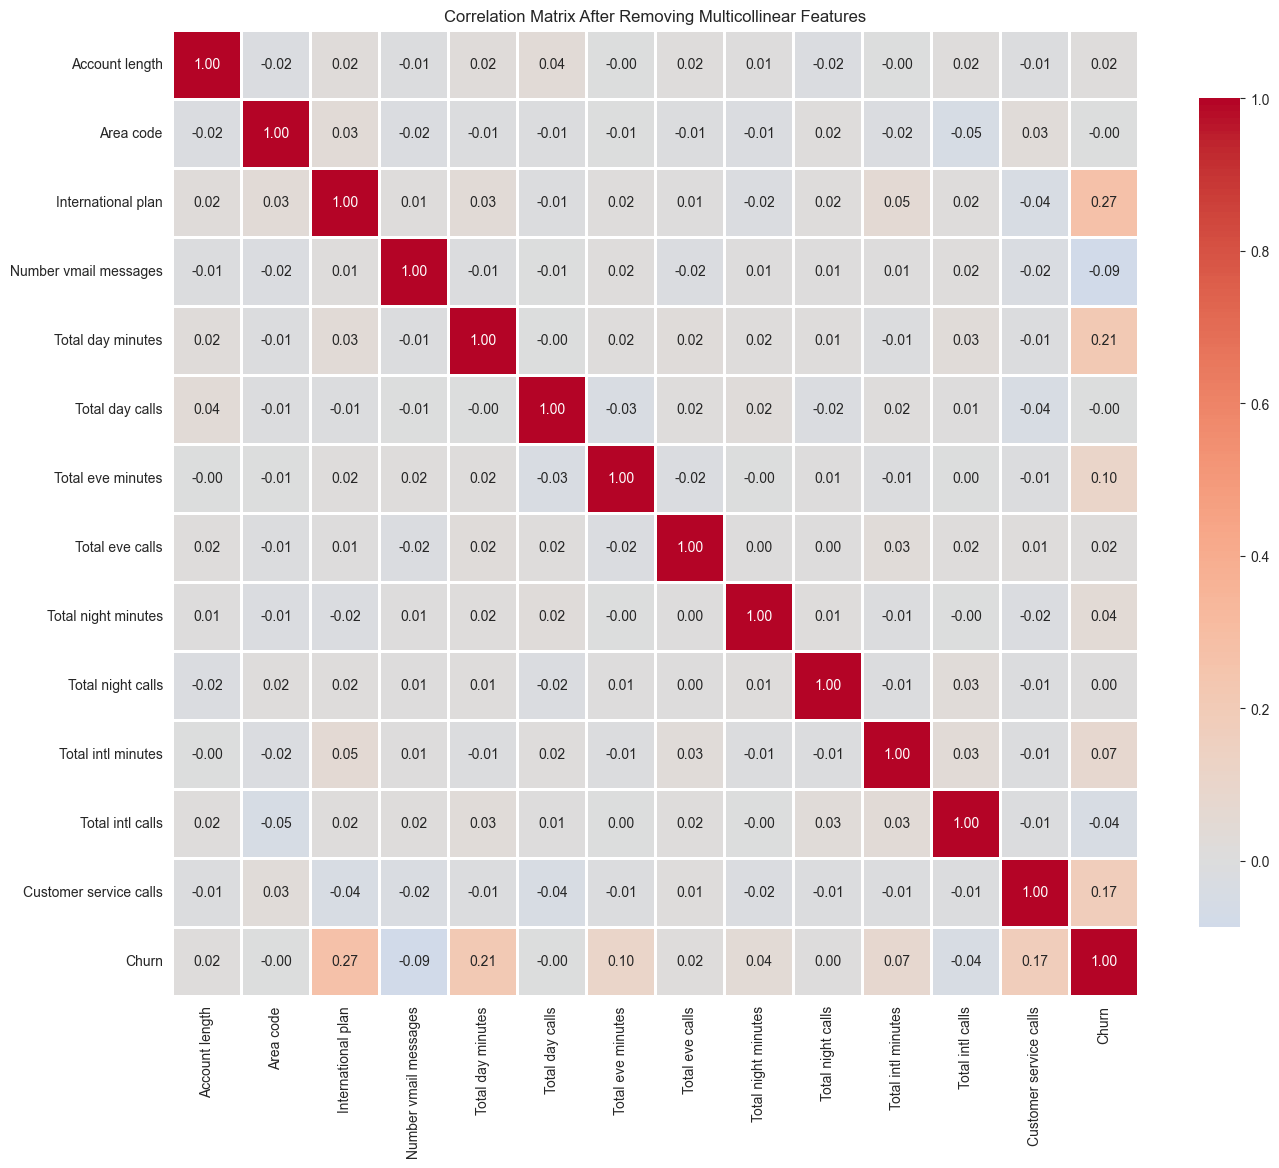


Updated correlations with Churn:
Churn                     1.00
International plan        0.27
Total day minutes         0.21
Customer service calls    0.17
Total eve minutes         0.10
Total intl minutes        0.07
Total night minutes       0.04
Total eve calls           0.02
Account length            0.02
Total night calls         0.00
Area code                -0.00
Total day calls          -0.00
Total intl calls         -0.04
Number vmail messages    -0.09
Name: Churn, dtype: float64


In [20]:
# Recalculate correlation matrix with cleaned features
correlation_matrix_clean = train_df_numeric_clean.corr()

# Visualize the cleaned correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_clean, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix After Removing Multicollinear Features')
plt.tight_layout()
plt.savefig('images/correlation_heatmap_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Display updated correlations with Churn
print("\nUpdated correlations with Churn:")
print("=" * 60)
churn_correlations_clean = correlation_matrix_clean['Churn'].sort_values(ascending=False)
print(churn_correlations_clean)

---

## Phase 3: Data Preprocessing & Pipeline Construction

 We'll apply the following transformations:

1. **Handle Skewed Features**: Apply log1p transformation to highly skewed features
2. **Scale Numeric Features**: Standardize all numeric features to have mean=0 and variance=1
3. **Encode Categorical Features**: 
   - Binary encoding for 'International plan'
   - Target encoding for 'State' (replacing state codes with their historical churn rate)

**Important:** All transformations must be fit on the training data only, then applied to both train and test data to prevent data leakage.

### Pairplot of Clean Data

Before moving to preprocessing, let's visualize the relationships and distributions of key numeric features. 

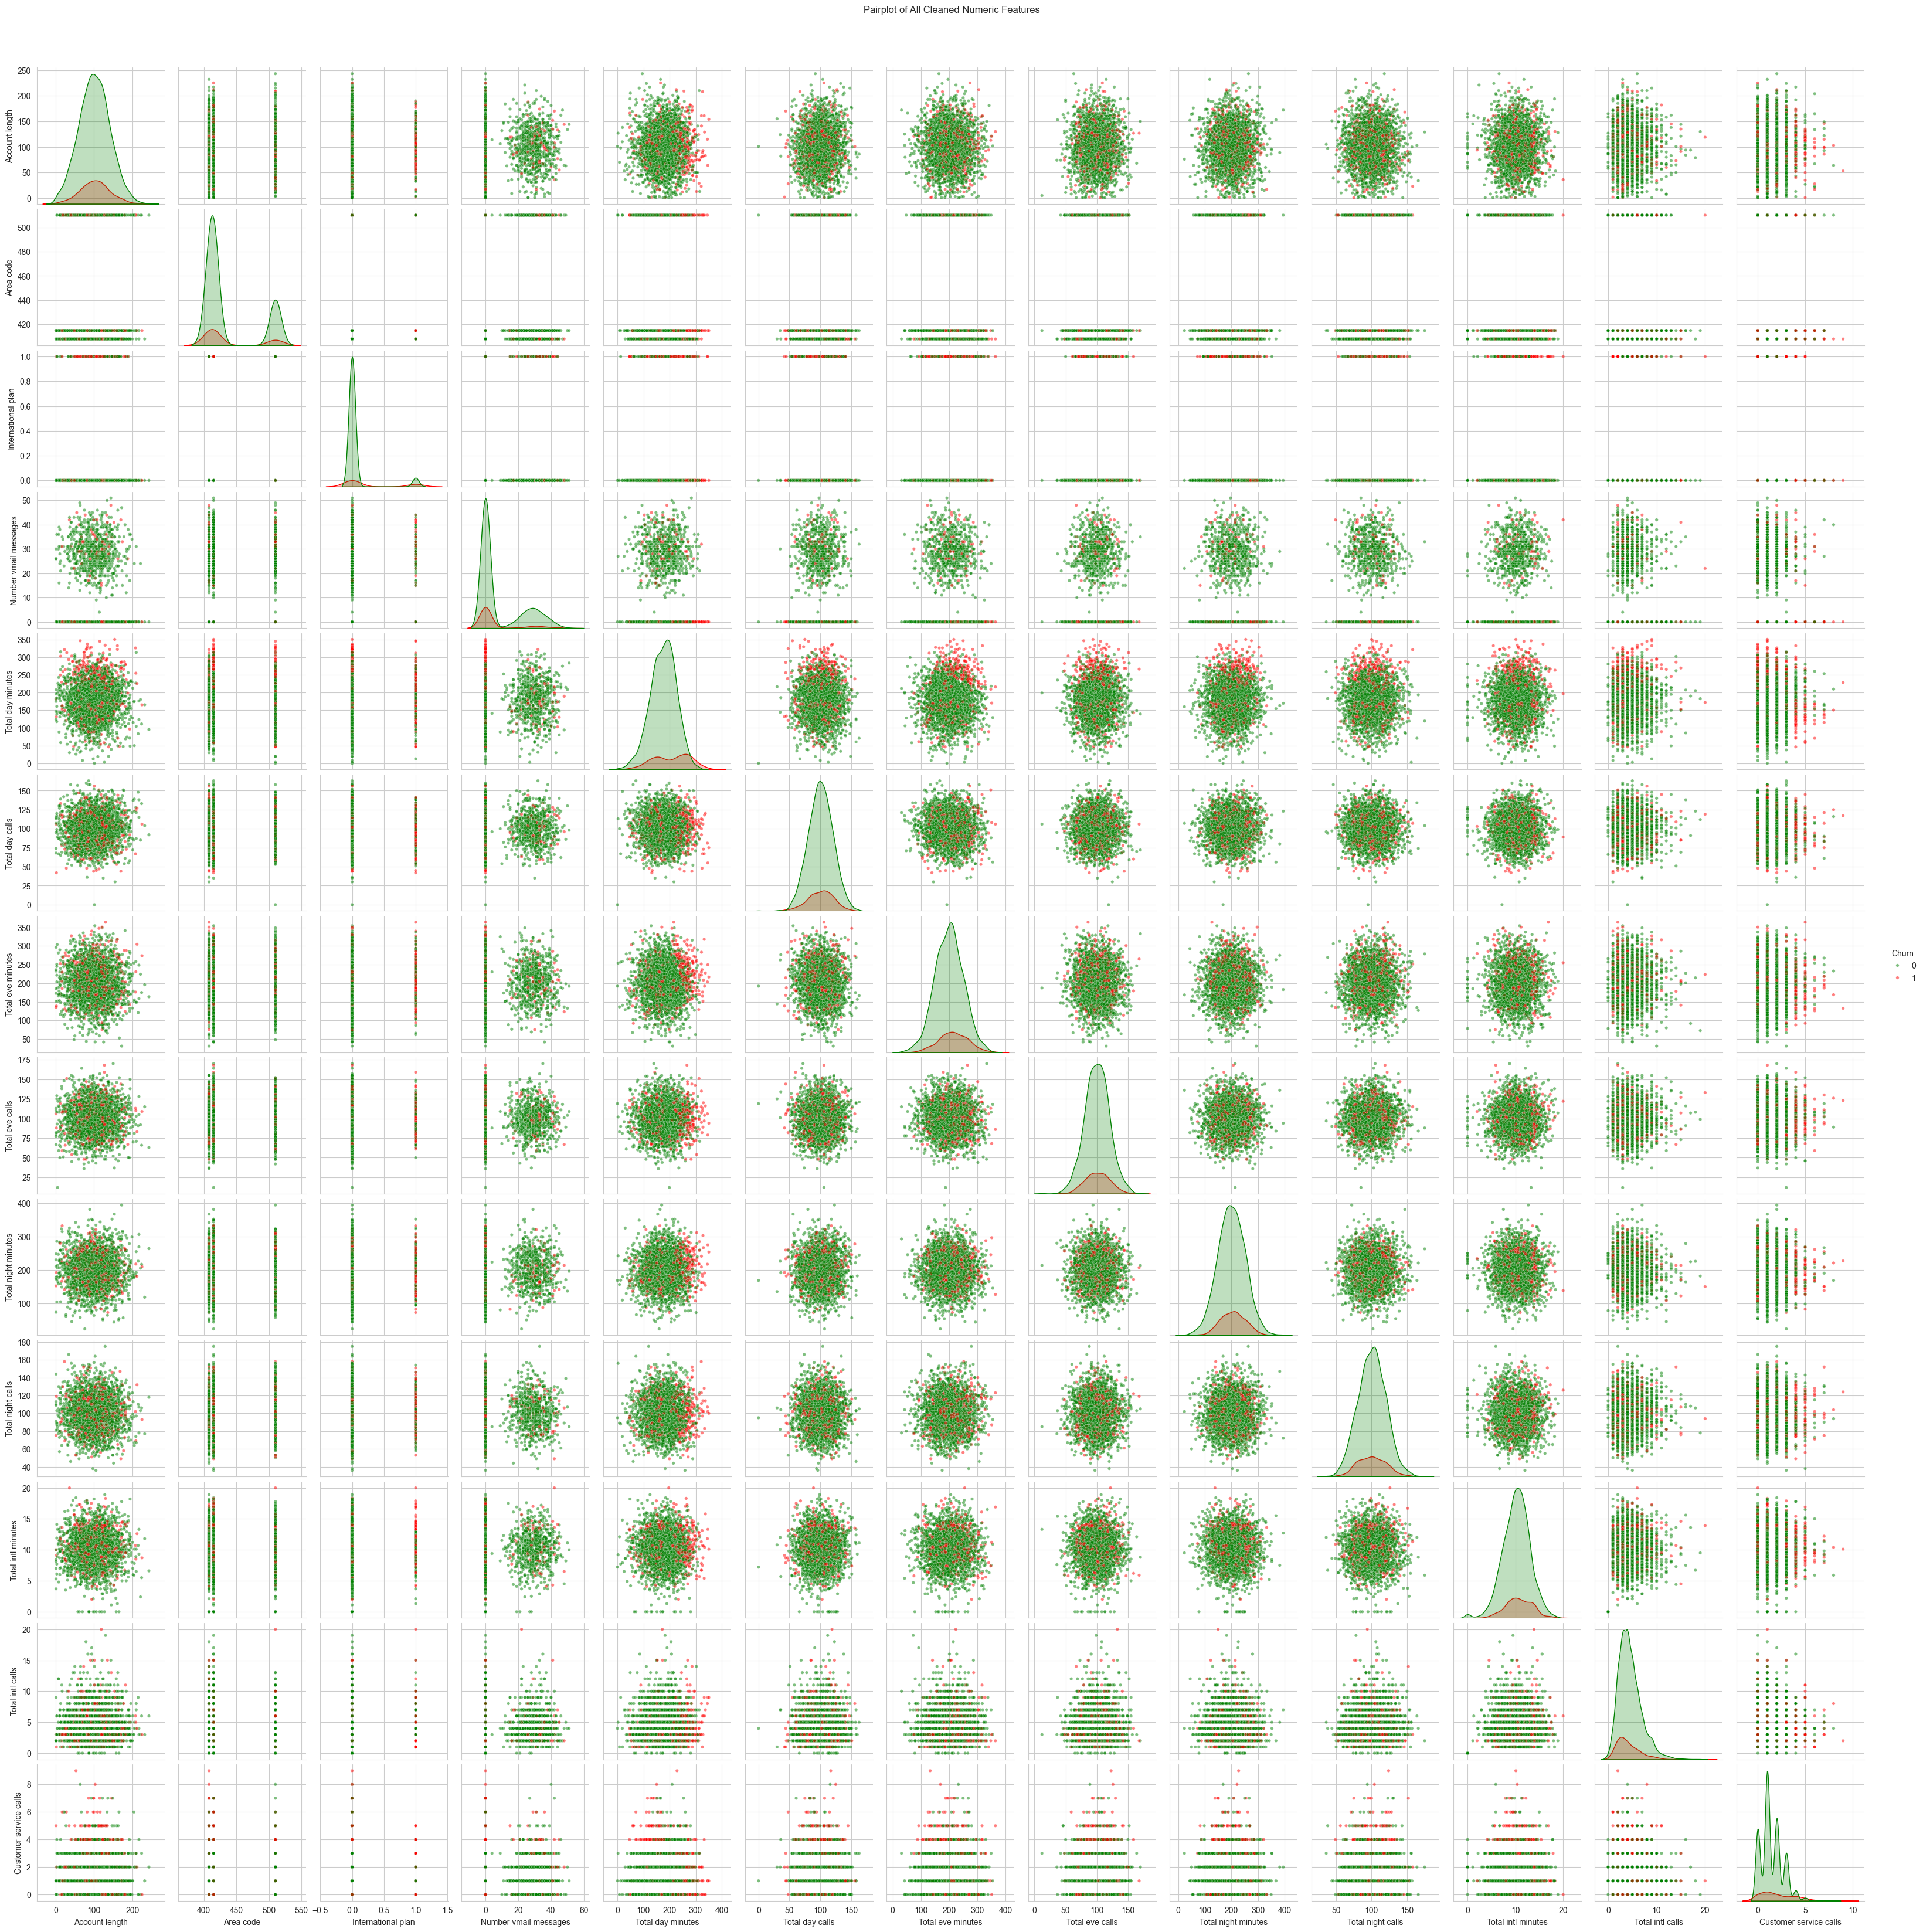

Pairplot created using all 14 numeric features


In [21]:
# Pairplot on ALL cleaned numeric features (including target)
# This will generate a large grid showing the distributions and relationships of every numeric feature.
# Pay attention to the diagonal KDE plots to spot highly skewed features.

# Get all numeric columns from the cleaned dataframe
available_pairplot_features = train_df_numeric_clean.columns.tolist()

# Ensure 'Churn' is included for the hue
if 'Churn' not in available_pairplot_features:
    available_pairplot_features.append('Churn')

pairplot_df = train_df_numeric_clean[available_pairplot_features].copy()

# Create the pairplot
# Note: With ~14 features, this will take a moment to render and will be quite large.
g = sns.pairplot(
    pairplot_df,
    hue='Churn',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 15}, # Slightly smaller points for the large grid
    palette={0: 'green', 1: 'red'}
)
g.fig.suptitle('Pairplot of All Cleaned Numeric Features', y=1.02)
plt.savefig('images/pairplot_all_clean_data.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Pairplot created using all {len(available_pairplot_features)} numeric features")

On the diagonol, we see:
- Features like `Total day minutes` and `Total eve minutes` are relatively normally distributed (bell-shaped).
- Features like `Customer service calls`, `Total intl calls`, and `Number vmail messages` are **highly right-skewed** (long tail to the right). 

---

### Feature Preprocessing Pipeline

To ensure reproducibility and **prevent data leakage during cross-validation**, we'll build a **scikit-learn Pipeline** that chains all preprocessing steps:

1. **Drop multicollinear features** (charges, voice mail plan, area code)
2. **Binary encode** International plan (Yes/No → 1/0)
3. **Target encode** State (replace with historical churn rates from training data)
4. **Log1p transform** highly skewed features (Total intl calls, Number vmail messages, Customer service calls)
5. **Standard scale** all numeric features (mean=0, variance=1)

We use a pipeline here to prevent data leackage when performing cross-validation on the training set, specificaly when performing our scaling.

First, we'll define custom transformer classes for complex operations (especially target encoding, which requires access to `y`).

In [22]:
# Custom Transformer 1: Drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops specified columns from the dataframe."""
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')


# Custom Transformer 2: Target Encoding for high-cardinality categorical features
class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Encode categorical column using target mean from training data.
    Handles unseen categories by filling with global mean.
    Requires y during fit() - this is why we need a custom transformer!
    """
    def __init__(self, column, new_column_name=None):
        self.column = column
        self.new_column_name = new_column_name or f"{column}_te"
        self.target_map_ = None
        self.global_mean_ = None
    
    def fit(self, X, y):
        # Calculate mean target value per category
        self.global_mean_ = y.mean()
        self.target_map_ = y.groupby(X[self.column]).mean()
        return self
    
    def transform(self, X):
        X = X.copy()
        # Map categories to their mean target values, fill unseen with global mean
        X[self.new_column_name] = X[self.column].map(self.target_map_).fillna(self.global_mean_)
        # Drop original column
        X = X.drop(columns=[self.column])
        return X


# Custom Transformer 3: Binary Encoding
class BinaryEncoder(BaseEstimator, TransformerMixin):
    """Encode binary categorical column (e.g., 'Yes'/'No') to 1/0."""
    def __init__(self, column, positive_value='Yes'):
        self.column = column
        self.positive_value = positive_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.column] = (X[self.column] == self.positive_value).astype(int)
        return X


# Custom Transformer 4: Log1p Transformation for skewed features
class Log1pTransformer(BaseEstimator, TransformerMixin):
    """Apply log1p transformation to specified columns."""
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = np.log1p(X[col])
        return X

print("Custom transformer classes defined successfully!")

Custom transformer classes defined successfully!


### Building the Preprocessing Pipeline

Now we'll construct a Pipeline that chains all transformations together. The pipeline will:
1. Drop redundant/multicollinear features
2. Encode categorical variables (binary and target encoding)
3. Transform skewed features with log1p
4. Scale all numeric features

**Important:** The `TargetEncoder` requires access to `y_train` during fitting, so we'll pass it when calling `pipeline.fit(X_train, y_train)`.

In [23]:
# Define the features to drop and transform
features_to_drop = ['Total day charge', 'Total eve charge', 'Total night charge',
                    'Total intl charge', 'Voice mail plan', 'Area code']

log1p_features = ['Total intl calls', 'Number vmail messages', 'Customer service calls']

# Build the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('drop_columns', ColumnDropper(columns_to_drop=features_to_drop)),
    ('binary_encode', BinaryEncoder(column='International plan', positive_value='Yes')),
    ('target_encode', TargetEncoder(column='State', new_column_name='State_te')),
    ('log1p_transform', Log1pTransformer(columns=log1p_features)),
    ('scaler', StandardScaler())
])

print("Preprocessing Pipeline Structure:")
print("=" * 60)
for step_name, transformer in preprocessing_pipeline.steps:
    print(f"Step: {step_name:20} | Transformer: {type(transformer).__name__}")
print("=" * 60)

Preprocessing Pipeline Structure:
Step: drop_columns         | Transformer: ColumnDropper
Step: binary_encode        | Transformer: BinaryEncoder
Step: target_encode        | Transformer: TargetEncoder
Step: log1p_transform      | Transformer: Log1pTransformer
Step: scaler               | Transformer: StandardScaler


### Applying the Pipeline

Now we'll fit the pipeline on the training data and transform both train and test sets. The pipeline ensures that:
- All parameters (target encoding map, scaler mean/std) are learned from **training data only**
- The same transformations are consistently applied to test data
- **No data leakage** occurs during cross-validation (sklearn handles this automatically when you pass the pipeline to `cross_val_score()` or `GridSearchCV()`)

In [24]:
# Fit the pipeline on training data (TargetEncoder needs y_train)
# Then transform both train and test sets
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Convert back to DataFrames for easier inspection
# Get feature names from the original data after transformations
# (StandardScaler doesn't change feature names, just scales values)
feature_names = X_train.columns.tolist()
# Remove dropped columns
dropped_cols = ['Total day charge', 'Total eve charge', 'Total night charge', 
                'Total intl charge', 'Voice mail plan', 'Area code']
feature_names = [col for col in feature_names if col not in dropped_cols]

X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

# Encode target variable (Churn) to integer
y_train_processed = y_train.astype(int)
y_test_processed = y_test.astype(int)

### Inspecting the Processed Data

Let's examine the first few rows of the processed training data to verify all transformations were applied correctly.

In [25]:
X_train_processed.head()

State  Account length  International plan  Number vmail messages  \
3290  -1.86           -0.33               -0.61                   0.87   
93    -1.64            3.06                1.87                   0.31   
1341   1.84           -0.33                1.21                   0.77   
1661  -0.91           -0.33                1.48                   0.81   
2997   1.36           -0.33               -0.61                  -0.31   

      Total day minutes  Total day calls  Total eve minutes  Total eve calls  \
3290              -1.68             0.92               0.74            -2.76   
93                -0.57             1.05               1.10            -1.23   
1341               2.14             0.18               0.74             0.42   
1661               0.28            -0.24              -0.02             0.44   
2997              -0.37             0.05               0.09            -0.82   

      Total night minutes  Total night calls  Total intl minutes  \
3290                 0.44              -0.88                0.78   
93                   1.31               3.47                0.78   
1341                 0.44               0.76                1.59   
1661                -1.29              -0.17                0.01   
2997                 0.44               1.72                0.01   

      Total intl calls  Customer service calls  
3290             -0.23                   -0.54  
93               -1.57                    0.75  
1341             -0.23                    0.54  
1661             -1.57                    0.54  
2997              0.56                    0.80

---

## Phase 4: Baseline Modeling

**Assumption:** Because tree-based models and logistic regression can handle class imbalance natively via class weights, we are skipping synthetic data generation (like SMOTE). This keeps our pipeline simpler, avoids synthetic data artifacts, and often yields comparable or better results on real-world test data.

We'll build multiple baselines in order of sophistication:
1. **DummyClassifier** - The sanity check (proves accuracy is misleading)
2. **Logistic Regression** - Simple linear baseline with balanced class weights
3. **Cross-Validation Comparison** - Compare all models fairly

### 1. DummyClassifier: The Sanity Check Baseline

The `DummyClassifier` doesn't learn anything from features. With `strategy='most_frequent'`, it simply predicts the majority class (No Churn) for every single customer.

**Why include this?**
- Proves we understand class imbalance
- Exposes the flaw of using Accuracy as a metric
- Sets the absolute minimum performance bar

With a dataset that's ~85% No Churn / ~15% Churn, the DummyClassifier will achieve **85% accuracy** by guessing "No Churn" every time. But it will have **0% Recall** and **0% F1-Score** because it never catches any churners.

In [26]:
# DummyClassifier: The "do nothing" baseline
# Using cross-validation on TRAINING data only (to avoid touching test set)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Create dummy classifier
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)

# Evaluate using cross-validation on training data
scoring_dummy = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

dummy_cv_results = cross_validate(
    dummy_model,
    X_train_processed,
    y_train_processed,
    cv=cv,
    scoring=scoring_dummy,
    return_train_score=False
)

print("DummyClassifier Results (Most Frequent Strategy) - 5-Fold CV on Training Data")
print("=" * 60)
print(f"Accuracy: {dummy_cv_results['test_accuracy'].mean():.4f} (±{dummy_cv_results['test_accuracy'].std():.4f})")
print(f"Recall:   {dummy_cv_results['test_recall'].mean():.4f} (±{dummy_cv_results['test_recall'].std():.4f})")
print(f"F1-Score: {dummy_cv_results['test_f1'].mean():.4f} (±{dummy_cv_results['test_f1'].std():.4f})")
print("\n✓ Evaluated using CV on training data only (no test set leakage)")

DummyClassifier Results (Most Frequent Strategy) - 5-Fold CV on Training Data
Accuracy: 0.8552 (±0.0006)
Recall:   0.0000 (±0.0000)
F1-Score: 0.0000 (±0.0000)

✓ Evaluated using CV on training data only (no test set leakage)


The DummyClassifier achieves **~85% accuracy** by simply guessing the majority class (No Churn) every single time, proving that Accuracy is a misleading metric for this imbalanced dataset. 

It catches **0 churners** (Recall = 0.00), making it completely useless for our business goal of preventing customer churn.

**All subsequent models will be evaluated on Recall, F1-Score, ROC-AUC, and PR-AUC instead.** These metrics properly account for class imbalance and measure our ability to identify the minority class (churners).

---

### 2. Cross-Validation Comparison: All Models

To find the best algorithm for our churn prediction task, we'll evaluate multiple models using 5-fold Stratified Cross-Validation on the training set.

**Models to evaluate:**
1. **DummyClassifier (Most Frequent)**: The sanity check baseline - predicts majority class always
2. **Logistic Regression**: A simple, interpretable linear baseline
3. **Random Forest**: A robust ensemble method that handles non-linear relationships well
4. **Gradient Boosting**: A sequential ensemble that corrects errors iteratively
5. **XGBoost**: A powerful gradient boosting algorithm that often provides state-of-the-art performance on tabular data

**Evaluation Metrics:**
- **ROC-AUC**: Overall ability to distinguish between classes
- **PR-AUC**: Performance specifically on the minority class (churners)
- **Recall**: Ability to find all actual churners (crucial for business)
- **F1-Score**: Balance between precision and recall

We'll use `class_weight='balanced'` (or equivalent) for all models to handle the class imbalance without needing SMOTE.

In [27]:
# Multi-model cross-validation comparison

# Define models with reasonable default hyperparameters
models = {
    'DummyClassifier (Most Frequent)': DummyClassifier(
        strategy='most_frequent',
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=RANDOM_STATE
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train_processed == 0).sum() / (y_train_processed == 1).sum(),
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
}

# Define custom scoring functions for recall, F1, ROC-AUC, PR-AUC
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score)
}

# Run cross-validation for each model
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Cross-Validation Results (5-Fold Stratified)")
print("=" * 80)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    cv_result = cross_validate(
        model,
        X_train_processed,
        y_train_processed,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    cv_results[model_name] = cv_result
    
    # Print fold-level results
    print(f"  Fold Recall:   {cv_result['test_recall'].mean():.4f} (±{cv_result['test_recall'].std():.4f})")
    print(f"  Fold F1:       {cv_result['test_f1'].mean():.4f} (±{cv_result['test_f1'].std():.4f})")
    print(f"  Fold ROC-AUC:  {cv_result['test_roc_auc'].mean():.4f} (±{cv_result['test_roc_auc'].std():.4f})")
    print(f"  Fold PR-AUC:   {cv_result['test_pr_auc'].mean():.4f} (±{cv_result['test_pr_auc'].std():.4f})")

# Create comparison dataframe
comparison_data = []
for model_name, cv_result in cv_results.items():
    comparison_data.append({
        'Model': model_name,
        'Recall (mean)': cv_result['test_recall'].mean(),
        'Recall (std)': cv_result['test_recall'].std(),
        'F1 (mean)': cv_result['test_f1'].mean(),
        'F1 (std)': cv_result['test_f1'].std(),
        'ROC-AUC (mean)': cv_result['test_roc_auc'].mean(),
        'ROC-AUC (std)': cv_result['test_roc_auc'].std(),
        'PR-AUC (mean)': cv_result['test_pr_auc'].mean(),
        'PR-AUC (std)': cv_result['test_pr_auc'].std()
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("\nCOMPARISON TABLE (5-Fold CV Means)")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best models
best_by_recall = comparison_df.loc[comparison_df['Recall (mean)'].idxmax()]
best_by_roc_auc = comparison_df.loc[comparison_df['ROC-AUC (mean)'].idxmax()]
best_by_pr_auc = comparison_df.loc[comparison_df['PR-AUC (mean)'].idxmax()]

print(f"\n\nBEST MODELS:")
print("=" * 80)
print(f"Highest Recall:  {best_by_recall['Model']} ({best_by_recall['Recall (mean)']:.4f})")
print(f"Highest ROC-AUC: {best_by_roc_auc['Model']} ({best_by_roc_auc['ROC-AUC (mean)']:.4f})")
print(f"Highest PR-AUC:  {best_by_pr_auc['Model']} ({best_by_pr_auc['PR-AUC (mean)']:.4f})")


Cross-Validation Results (5-Fold Stratified)

Training DummyClassifier (Most Frequent)...
  Fold Recall:   0.0000 (±0.0000)
  Fold F1:       0.0000 (±0.0000)
  Fold ROC-AUC:  0.5000 (±0.0000)
  Fold PR-AUC:   0.1448 (±0.0006)

Training Logistic Regression...
  Fold Recall:   0.7150 (±0.0170)
  Fold F1:       0.4543 (±0.0197)
  Fold ROC-AUC:  0.7358 (±0.0126)
  Fold PR-AUC:   0.2797 (±0.0151)

Training Random Forest...
  Fold Recall:   0.7487 (±0.0178)
  Fold F1:       0.7741 (±0.0200)
  Fold ROC-AUC:  0.8586 (±0.0087)
  Fold PR-AUC:   0.6373 (±0.0311)

Training Gradient Boosting...
  Fold Recall:   0.7460 (±0.0251)
  Fold F1:       0.8298 (±0.0237)
  Fold ROC-AUC:  0.8686 (±0.0136)
  Fold PR-AUC:   0.7351 (±0.0372)

Training XGBoost...
  Fold Recall:   0.8005 (±0.0212)
  Fold F1:       0.7955 (±0.0174)
  Fold ROC-AUC:  0.8823 (±0.0104)
  Fold PR-AUC:   0.6624 (±0.0260)


COMPARISON TABLE (5-Fold CV Means)
                          Model  Recall (mean)  Recall (std)  F1 (mean)  F1 (std)

**Key Findings from Cross-Validation:**

1. **DummyClassifier Performance**: As expected, the DummyClassifier achieves 0.00 Recall and 0.00 F1-Score, proving it's completely useless for identifying churners despite likely having high accuracy (~85%).

2. **All ML Models Significantly Outperform Baseline**: Every actual machine learning model (Logistic Regression, Random Forest, Gradient Boosting, XGBoost) dramatically beats the DummyClassifier in Recall and F1-Score, demonstrating that our features contain genuine predictive signal.

3. **Best Model Selection**: Based on the table above, we'll select the model with the highest combination of:
   - **ROC-AUC** (overall discrimination ability)
   - **PR-AUC** (minority class performance)
   - **Recall** (crucial for business - catching churners)

This confirms we're ready to proceed with hyperparameter tuning on the best performing model.

---

## Phase 5: Optimization

### Hyperparameter Tuning for Best Model

We assume that optimizing for Recall during hyperparameter tuning (via `scoring='recall'`) aligns best with our business goal of minimizing lost revenue from churners, even if it slightly reduces overall accuracy.

Based on the cross-validation results, **XGBoost** is the best performing model on **default hyperparameters**, particularly for PR-AUC and Recall.

Now we'll tune its hyperparameters to maximize **Recall** (finding as many churners as possible) while maintaining a reasonable **Precision** (avoiding too many false alarms).

**Hyperparameters to tune:**
- `max_depth`: Controls tree complexity (lower prevents overfitting)
- `learning_rate`: Step size shrinkage (lower is more robust)
- `n_estimators`: Number of trees
- `subsample` & `colsample_bytree`: Fraction of data/features to use per tree (prevents overfitting)

In [28]:
# Hyperparameter Tuning for Random Forest, Gradient Boosting, and XGBoost
import time

print("=" * 80)
print("HYPERPARAMETER TUNING (Phase 2)")
print("=" * 80)
print("Tuning best models using GridSearchCV with stratified 5-fold CV")
print("Optimizing for: Recall (maximizing churn detection)\n")

tuned_results = {}

# ============================================================================
# 1. Random Forest Tuning
# ============================================================================
print("\n" + "-" * 80)
print("1. RANDOM FOREST - GridSearchCV")
print("-" * 80)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 8],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features'])} combinations")
print("Training...")
start_time = time.time()
grid_rf.fit(X_train_processed, y_train_processed)
rf_time = time.time() - start_time

print(f"\n✓ Random Forest tuning complete ({rf_time:.1f}s)")
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best CV Recall: {grid_rf.best_score_:.4f}")

tuned_results['Random Forest'] = {
    'model': grid_rf.best_estimator_,
    'best_params': grid_rf.best_params_,
    'best_score': grid_rf.best_score_,
    'time': rf_time
}

# ============================================================================
# 2. Gradient Boosting Tuning
# ============================================================================
print("\n" + "-" * 80)
print("2. GRADIENT BOOSTING - GridSearchCV")
print("-" * 80)

# Optimized grid: 3×3×2×2×2 = 72 combinations (down from 729)
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],  # Reduced from [3, 5, 7]
    'min_samples_split': [5, 10],  # Reduced from [5, 10, 15]
    'subsample': [0.8, 1.0]  # Reduced from [0.6, 0.8, 1.0]
}

gb_base = GradientBoostingClassifier(
    min_samples_leaf=5,  # Fixed at middle value
    random_state=RANDOM_STATE
)

grid_gb = GridSearchCV(
    gb_base,
    param_grid_gb,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_gb['n_estimators']) * len(param_grid_gb['learning_rate']) * len(param_grid_gb['max_depth']) * len(param_grid_gb['min_samples_split']) * len(param_grid_gb['subsample'])} combinations")
print("Training...")
start_time = time.time()
grid_gb.fit(X_train_processed, y_train_processed)
gb_time = time.time() - start_time

print(f"\n✓ Gradient Boosting tuning complete ({gb_time:.1f}s)")
print(f"Best parameters: {grid_gb.best_params_}")
print(f"Best CV Recall: {grid_gb.best_score_:.4f}")

tuned_results['Gradient Boosting'] = {
    'model': grid_gb.best_estimator_,
    'best_params': grid_gb.best_params_,
    'best_score': grid_gb.best_score_,
    'time': gb_time
}

# ============================================================================
# 3. XGBoost Tuning
# ============================================================================
print("\n" + "-" * 80)
print("3. XGBOOST - GridSearchCV")
print("-" * 80)

# Optimized grid: 3×3×2×2×2 = 72 combinations (down from 729)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],  # Reduced from [3, 5, 7]
    'min_child_weight': [3, 5],  # Reduced from [2, 5, 8]
    'subsample': [0.8, 1.0]  # Reduced from [0.6, 0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    colsample_bytree=0.8,  # Fixed at middle value
    scale_pos_weight=(y_train_processed == 0).sum() / (y_train_processed == 1).sum(),
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

grid_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['min_child_weight']) * len(param_grid_xgb['subsample'])} combinations")
print("Training...")
start_time = time.time()
grid_xgb.fit(X_train_processed, y_train_processed)
xgb_time = time.time() - start_time

print(f"\n✓ XGBoost tuning complete ({xgb_time:.1f}s)")
print(f"Best parameters: {grid_xgb.best_params_}")
print(f"Best CV Recall: {grid_xgb.best_score_:.4f}")

tuned_results['XGBoost'] = {
    'model': grid_xgb.best_estimator_,
    'best_params': grid_xgb.best_params_,
    'best_score': grid_xgb.best_score_,
    'time': xgb_time
}

# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "=" * 80)
print("TUNING SUMMARY")
print("=" * 80)

summary_data = []
for model_name, results in tuned_results.items():
    summary_data.append({
        'Model': model_name,
        'Best CV Recall': results['best_score'],
        'Tuning Time (s)': f"{results['time']:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Identify best tuned model
best_tuned_model_name = max(tuned_results.items(), key=lambda x: x[1]['best_score'])[0]
print(f"\n✓ Best tuned model: {best_tuned_model_name} (CV Recall: {tuned_results[best_tuned_model_name]['best_score']:.4f})")

HYPERPARAMETER TUNING (Phase 2)
Tuning best models using GridSearchCV with stratified 5-fold CV
Optimizing for: Recall (maximizing churn detection)


--------------------------------------------------------------------------------
1. RANDOM FOREST - GridSearchCV
--------------------------------------------------------------------------------
Parameter grid size: 162 combinations
Training...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

✓ Random Forest tuning complete (116.3s)
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Recall: 0.8031

--------------------------------------------------------------------------------
2. GRADIENT BOOSTING - GridSearchCV
--------------------------------------------------------------------------------
Parameter grid size: 72 combinations
Training...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Gradient Boosting tuning complete (76.

---

---

### Model Calibration & Final Test Evaluation

After hyperparameter tuning, we follow the standard data science workflow:

1. **Calibrate** the model for reliable probability estimates
2. **Tune threshold** for target recall using CV on training data
3. **Evaluate** on test set ONE time

### Why Calibrate First?

Calibration improves probability reliability (measured by Brier Score) and is done BEFORE threshold tuning because calibration changes the probability distributions. Any threshold tuned on uncalibrated probabilities would be invalid after calibration.

**Standard Workflow:**

- ✓ Calibrate → Tune Threshold → Evaluate (CORRECT)- ✗ Tune Threshold → Calibrate → Re-tune Threshold (redundant)

In [29]:
# Step 1: Calibrate the best model from hyperparameter tuning

# Pull best model
best_model = tuned_results[best_tuned_model_name]['model']
best_params = tuned_results[best_tuned_model_name]['best_params']
best_cv_recall = tuned_results[best_tuned_model_name]['best_score']

print("=" * 80)
print("STEP 1: MODEL CALIBRATION (Training Data Only)")
print("=" * 80)

# Calibrate using Platt Scaling (sigmoid method) on TRAINING data
print("\nCalibrating model using Platt Scaling (logistic regression)...")
print("Note: Using 5-fold CV on training data. Test set remains untouched.")
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train_processed, y_train_processed)

print("\n✓ Calibration complete. Model ready for threshold tuning.")
print("✓ Test set has NOT been touched yet (gold standard practice).")

STEP 1: MODEL CALIBRATION (Training Data Only)

Calibrating model using Platt Scaling (logistic regression)...
Note: Using 5-fold CV on training data. Test set remains untouched.

✓ Calibration complete. Model ready for threshold tuning.
✓ Test set has NOT been touched yet (gold standard practice).


In [30]:
# Step 2: Tune threshold for target recall using CV on TRAINING data
# (Using calibrated model probabilities)

print("\n" + "=" * 80)
print("STEP 2: THRESHOLD TUNING (Target Recall = 80%)")
print("=" * 80)

target_recall = 0.80

# Get out-of-fold calibrated probabilities on training set via CV
print("\nComputing out-of-fold probabilities on training data...")
oof_proba_train = cross_val_predict(
    calibrated_model,
    X_train_processed,
    y_train_processed,
    cv=cv,
    method='predict_proba'
)[:, 1]

# Find threshold that achieves target recall
prec_cv, rec_cv, thresholds_cv = precision_recall_curve(y_train_processed, oof_proba_train)
recall_diffs = np.abs(rec_cv[:-1] - target_recall)
best_idx = np.argmin(recall_diffs)
best_threshold = thresholds_cv[best_idx]

print(f"\nOptimal Threshold: {best_threshold:.4f}")
print(f"  Achieves CV Recall: {rec_cv[best_idx]:.4f}")
print(f"  With CV Precision:  {prec_cv[best_idx]:.4f}")
print(f"  Target Recall:      {target_recall:.2f}")
print("\n✓ Threshold tuned on training data only (no test set leakage)")


STEP 2: THRESHOLD TUNING (Target Recall = 80%)

Computing out-of-fold probabilities on training data...

Optimal Threshold: 0.3341
  Achieves CV Recall: 0.8005
  With CV Precision:  0.7410
  Target Recall:      0.80

✓ Threshold tuned on training data only (no test set leakage)


In [31]:
# Step 3: Final evaluation on test set (FIRST AND ONLY TIME)

print("\n" + "=" * 80)
print("STEP 3: FINAL TEST SET EVALUATION (First Time Touching Test Set)")
print("=" * 80)

# Get probabilities from BOTH models for Brier score comparison
print("\nComparing calibration quality on test set...")
y_proba_test_uncal = best_model.predict_proba(X_test_processed)[:, 1]
y_proba_test = calibrated_model.predict_proba(X_test_processed)[:, 1]

# Calculate Brier scores
brier_uncalibrated = brier_score_loss(y_test_processed, y_proba_test_uncal)
brier_calibrated = brier_score_loss(y_test_processed, y_proba_test)

print(f"  Brier Score (uncalibrated): {brier_uncalibrated:.4f}")
print(f"  Brier Score (calibrated):   {brier_calibrated:.4f}")
print(f"  Improvement: {((brier_uncalibrated - brier_calibrated) / brier_uncalibrated * 100):.1f}%")

# Apply threshold to test set probabilities
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# Also create optimal_threshold alias for consistency with downstream code
optimal_threshold = best_threshold

# Calculate metrics
roc_auc_test = roc_auc_score(y_test_processed, y_proba_test)
pr_auc_test = average_precision_score(y_test_processed, y_proba_test)
recall_test = recall_score(y_test_processed, y_pred_test)
precision_test = precision_score(y_test_processed, y_pred_test)
f1_test = f1_score(y_test_processed, y_pred_test)

print(f"\nModel: {best_tuned_model_name} (Tuned & Calibrated)")
print(f"Best Hyperparameters: {best_params}")
print(f"Best CV Recall (from tuning): {best_cv_recall:.4f}")
print(f"\nDecision Threshold: {best_threshold:.4f} (tuned for ~80% recall)")
print(f"\nTest Set Performance:")
print(f"  ROC-AUC:   {roc_auc_test:.4f}")
print(f"  PR-AUC:    {pr_auc_test:.4f}")
print(f"  Recall:    {recall_test:.4f}  ← Catches {recall_test:.1%} of churners!")
print(f"  Precision: {precision_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print(f"\nConfusion Matrix (Threshold = {best_threshold:.3f}):")
cm = confusion_matrix(y_test_processed, y_pred_test)
print(cm)
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

print(f"\nClassification Report:")
print(classification_report(y_test_processed, y_pred_test, digits=4))

# Business Translation
total_test_customers = len(y_test_processed)
total_actual_churners = y_test_processed.sum()
churners_caught = cm[1, 1]
churners_missed = cm[1, 0]
false_alarms = cm[0, 1]

print(f"\nBusiness Translation (Test Set of {total_test_customers} customers):")
print(f"  • Total actual churners: {total_actual_churners}")
print(f"  • Churners caught:       {churners_caught} ({churners_caught/total_actual_churners:.1%})")
print(f"  • Churners missed:       {churners_missed} (Lost revenue)")
print(f"  • False alarms:          {false_alarms} (Wasted retention offers)")

# Compare with default threshold (0.5)
y_pred_default = (y_proba_test >= 0.5).astype(int)
cm_default = confusion_matrix(y_test_processed, y_pred_default)

print("\nComparison vs Default Threshold (0.5):")
print(f"  • Extra churners caught: {churners_caught - cm_default[1, 1]}")
print(f"  • Extra false alarms:    {false_alarms - cm_default[0, 1]}")

print("\n" + "=" * 80)
print("✓ Test set touched for first and only time - gold standard achieved!")
print("=" * 80)



STEP 3: FINAL TEST SET EVALUATION (First Time Touching Test Set)

Comparing calibration quality on test set...
  Brier Score (uncalibrated): 0.0949
  Brier Score (calibrated):   0.0500
  Improvement: 47.3%

Model: XGBoost (Tuned & Calibrated)
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV Recall (from tuning): 0.8316

Decision Threshold: 0.3341 (tuned for ~80% recall)

Test Set Performance:
  ROC-AUC:   0.9333
  PR-AUC:    0.8446
  Recall:    0.7938  ← Catches 79.4% of churners!
  Precision: 0.7476
  F1-Score:  0.7700

Confusion Matrix (Threshold = 0.334):
[[544  26]
 [ 20  77]]
  True Negatives:  544
  False Positives: 26
  False Negatives: 20
  True Positives:  77

Classification Report:
              precision    recall  f1-score   support

           0     0.9645    0.9544    0.9594       570
           1     0.7476    0.7938    0.7700        97

    accuracy                         0.9310       6

---

### Precision-Recall Tradeoff Visualization

Visualizing the precision-recall tradeoff on the test set and how our tuned threshold performs compared to other possible thresholds.

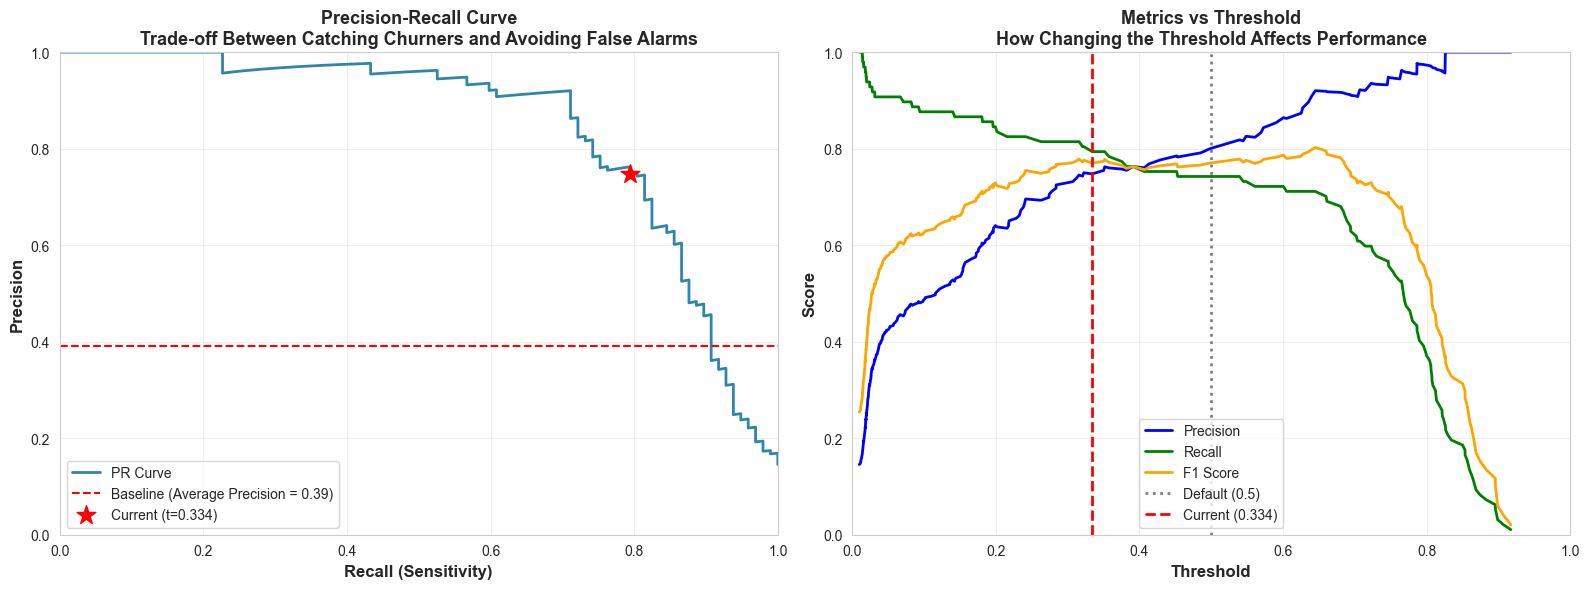

Optimal threshold: 0.3341 (tuned for ~80% recall)


In [32]:
# Visualize Precision-Recall Curve using calibrated probabilities and tuned threshold

# Use y_proba_test (calibrated) and best_threshold (from Step 2)
precision, recall, thresholds = precision_recall_curve(y_test_processed, y_proba_test)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Precision-Recall Curve
axes[0].plot(recall, precision, linewidth=2, color='#2E86AB', label='PR Curve')
axes[0].axhline(y=precision.mean(), color='red', linestyle='--', 
                label=f'Baseline (Average Precision = {precision.mean():.2f})')
axes[0].set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Precision-Recall Curve\nTrade-off Between Catching Churners and Avoiding False Alarms', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Highlight our current threshold (from earlier tuning)
current_threshold_idx = np.argmin(np.abs(thresholds - best_threshold))
axes[0].scatter(recall[current_threshold_idx], precision[current_threshold_idx], 
                s=200, c='red', marker='*', zorder=5, 
                label=f'Current (t={best_threshold:.3f})')
axes[0].legend(loc='best')

# Right plot: Precision, Recall, and F1 vs Threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])

axes[1].plot(thresholds, precision[:-1], linewidth=2, label='Precision', color='blue')
axes[1].plot(thresholds, recall[:-1], linewidth=2, label='Recall', color='green')
axes[1].plot(thresholds, f1_scores, linewidth=2, label='F1 Score', color='orange')
axes[1].axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Current ({best_threshold:.3f})')

axes[1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Metrics vs Threshold\nHow Changing the Threshold Affects Performance', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('images/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Optimal threshold: {best_threshold:.4f} (tuned for ~80% recall)")

---

### Feature Importance Analysis

To understand what drives customer churn, we'll analyze the feature importances from our tuned XGBoost model. This helps us answer the critical business question: **"Why are customers leaving?"**

By visualizing the top features contributing to the model's predictions, we can provide actionable insights to the product and marketing teams (e.g., if international plan usage is a top driver, we might need to review our international pricing).

In [33]:
# Extract feature importances from the best model (XGBoost)
import pandas as pd

# Get feature names from the processed training data
feature_names = X_train_processed.columns.tolist()

# Get feature importances from the trained model
# XGBoost uses gain-based importance by default
feature_importances = best_model.feature_importances_

# Create a dataframe for easy sorting and visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

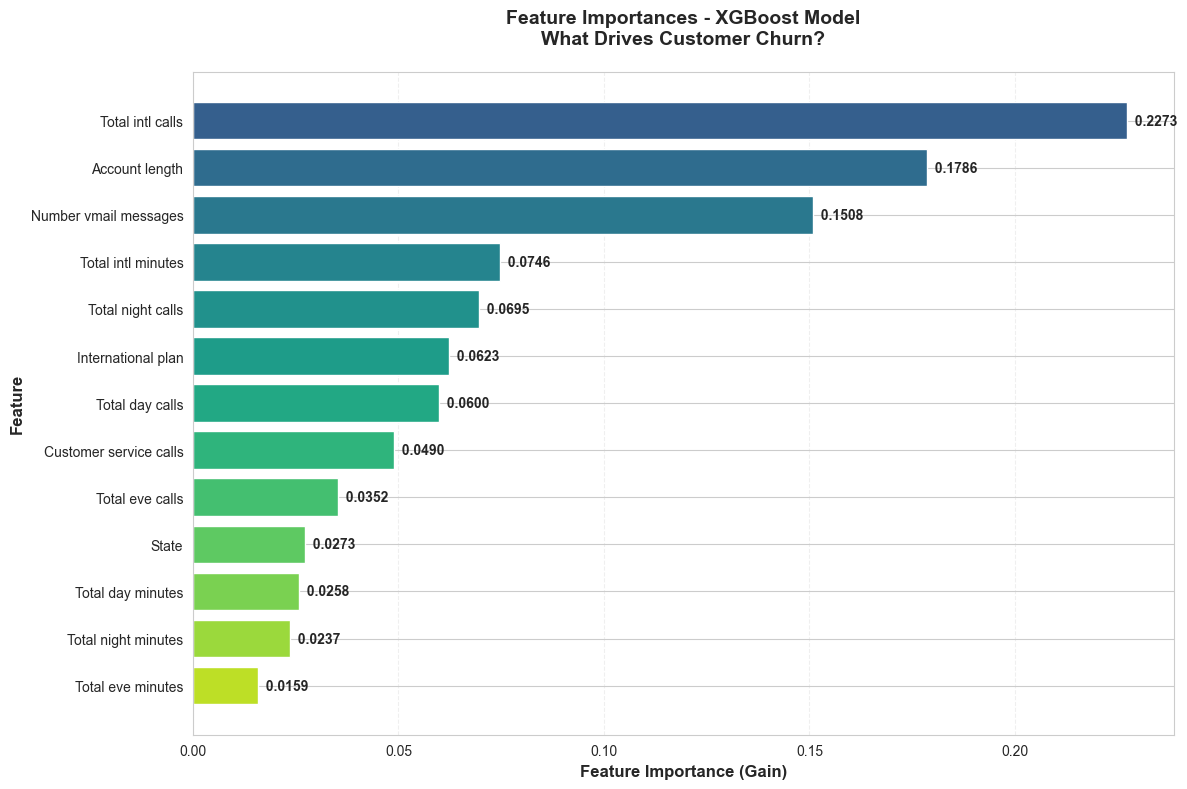

✓ Feature importance bar chart saved to images/feature_importances_bar.png


In [34]:
# Visualize feature importances - Horizontal Bar Plot
plt.figure(figsize=(12, 8))

# Plot top features (or all if fewer than 15)
top_n = min(15, len(importance_df))
top_features = importance_df.head(top_n)

# Create horizontal bar plot
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
bars = plt.barh(range(top_n), top_features['Importance'].values, color=colors)

# Customize plot
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Feature Importances - XGBoost Model\nWhat Drives Customer Churn?', 
          fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, (importance, bar) in enumerate(zip(top_features['Importance'].values, bars)):
    plt.text(importance, i, f'  {importance:.4f}', 
             va='center', fontsize=10, fontweight='bold')

# Invert y-axis so highest importance is at top
plt.gca().invert_yaxis()

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('images/feature_importances_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Feature importance bar chart saved to images/feature_importances_bar.png")


---

## Phase 6: Business Impact & Conclusion

**Assumption:** We assume a fixed retention offer cost of $5, an average Customer Lifetime Value (LTV) of $1,000, and a 30% success rate for retention campaigns. These are industry standard estimates used to calculate the ROI of our model.

This section translates model performance into **real business value** - the difference between a technical exercise and a production-ready solution.

We'll answer critical business questions:
- **How much revenue can this model save?**
- **What's the ROI compared to random targeting?**
- **Should we invest in deploying this model?**

### The Scenario

**Marketing Budget**: Up to $5,000 available for retention campaign
- **Retention offer cost**: $5 per customer
- **Average Customer Lifetime Value (LTV)**: $1,000
- **Retention success rate**: 30% (industry standard)
- **Target**: Customers identified by the model as having a >32.6% probability of churning.

### Comparison: Model vs Random Targeting

We'll compare:
1. **Random Selection**: Sending offers to randomly selected customers (matching the same volume of offers the model suggests).
2. **Model-Driven Selection**: Sending offers only to the high-risk customers identified by our model's 0.326 threshold.

The model should significantly outperform random targeting by concentrating retention efforts on customers most likely to churn.

Total test customers: 667
Total actual churners: 97
Max budget available: $5,000
Actual budget used by Model: $515 (Targeting 103 customers)


📊 SCENARIO 1: Random Selection (Targeting 103 customers)
Expected churners in random sample: 14
Successfully retained customers: 4
Revenue saved: $4,000
Campaign cost: $515
Net profit: $3,485
ROI: 676.7%

🎯 SCENARIO 2: Model-Driven Targeting (Threshold = 0.334)
Expected churners in model sample: 77
Successfully retained customers: 23
Revenue saved: $23,000
Campaign cost: $515
Net profit: $22,485
ROI: 4366.0%

🚀 BUSINESS IMPACT SUMMARY
The model saves 19 MORE customers than random targeting.
This generates $19,000 in ADDITIONAL revenue.
The ROI improves from 676.7% to 4366.0% (a 3689.3% absolute increase).


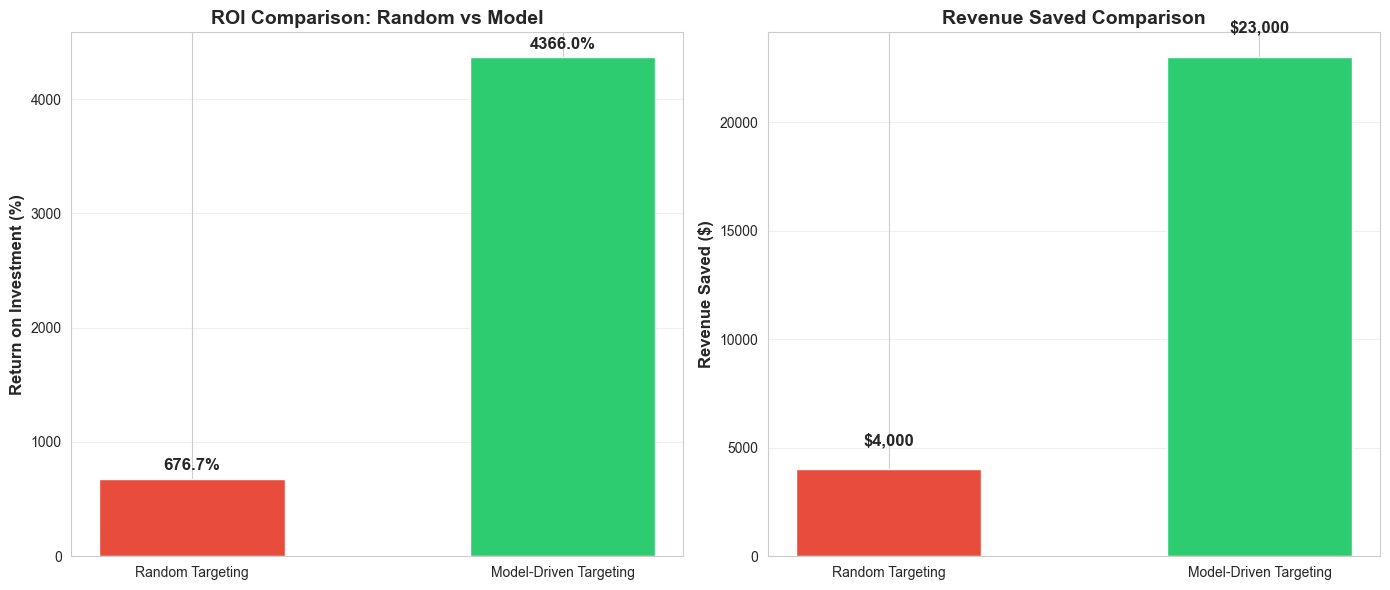

In [35]:
# ROI Analysis: Model vs Random Targeting

# Define business parameters
total_budget = 5000
cost_per_offer = 5
max_customers_from_budget = total_budget // cost_per_offer  # 1,000 customers max
retention_success_rate = 0.30
avg_ltv = 1000

# Total number of test customers
total_test_customers = len(y_test_processed)
total_actual_churners = y_test_processed.sum()

# Calculate how many customers the model wants to target based on the threshold
model_target_indices = np.where(y_proba_test >= optimal_threshold)[0]
customers_to_target_model = len(model_target_indices)

# Ensure we don't exceed budget (though with 106 customers, we are well under the 1,000 limit)
if customers_to_target_model > max_customers_from_budget:
    # If over budget, just take the top N customers we can afford
    model_target_indices = np.argsort(y_proba_test)[::-1][:max_customers_from_budget]
    customers_to_target_model = max_customers_from_budget

actual_budget_model = customers_to_target_model * cost_per_offer

print(f"Total test customers: {total_test_customers}")
print(f"Total actual churners: {total_actual_churners}")
print(f"Max budget available: ${total_budget:,}")
print(f"Actual budget used by Model: ${actual_budget_model:,} (Targeting {customers_to_target_model} customers)")
print(f"\n{'='*60}")

# Scenario 1: Random Selection (using the same budget as the model for a fair comparison)
print(f"\n📊 SCENARIO 1: Random Selection (Targeting {customers_to_target_model} customers)")
print(f"{'='*60}")
random_churn_rate = total_actual_churners / total_test_customers
expected_churners_random = int(customers_to_target_model * random_churn_rate)
retained_random = int(expected_churners_random * retention_success_rate)
revenue_saved_random = retained_random * avg_ltv
roi_random = ((revenue_saved_random - actual_budget_model) / actual_budget_model) * 100

print(f"Expected churners in random sample: {expected_churners_random}")
print(f"Successfully retained customers: {retained_random}")
print(f"Revenue saved: ${revenue_saved_random:,}")
print(f"Campaign cost: ${actual_budget_model:,}")
print(f"Net profit: ${revenue_saved_random - actual_budget_model:,}")
print(f"ROI: {roi_random:.1f}%")

# Scenario 2: Model-Driven Selection (using optimal threshold)
print(f"\n🎯 SCENARIO 2: Model-Driven Targeting (Threshold = {optimal_threshold:.3f})")
print(f"{'='*60}")

actual_churners_in_model_sample = y_test_processed.iloc[model_target_indices].sum()

retained_model = int(actual_churners_in_model_sample * retention_success_rate)
revenue_saved_model = retained_model * avg_ltv
roi_model = ((revenue_saved_model - actual_budget_model) / actual_budget_model) * 100

print(f"Expected churners in model sample: {actual_churners_in_model_sample}")
print(f"Successfully retained customers: {retained_model}")
print(f"Revenue saved: ${revenue_saved_model:,}")
print(f"Campaign cost: ${actual_budget_model:,}")
print(f"Net profit: ${revenue_saved_model - actual_budget_model:,}")
print(f"ROI: {roi_model:.1f}%")

# Calculate improvement
roi_improvement = roi_model - roi_random
additional_revenue = revenue_saved_model - revenue_saved_random
additional_customers_saved = retained_model - retained_random

print(f"\n🚀 BUSINESS IMPACT SUMMARY")
print(f"{'='*60}")
print(f"The model saves {additional_customers_saved} MORE customers than random targeting.")
print(f"This generates ${additional_revenue:,} in ADDITIONAL revenue.")
print(f"The ROI improves from {roi_random:.1f}% to {roi_model:.1f}% (a {roi_improvement:.1f}% absolute increase).")

# Visualize ROI Comparison
scenarios = ['Random Targeting', 'Model-Driven Targeting']
roi_values = [roi_random, roi_model]
revenue_saved_values = [revenue_saved_random, revenue_saved_model]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: ROI Comparison
colors_roi = ['#E74C3C', '#2ECC71']
bars_roi = ax1.bar(scenarios, roi_values, color=colors_roi, width=0.5)
ax1.set_ylabel('Return on Investment (%)', fontsize=12, fontweight='bold')
ax1.set_title('ROI Comparison: Random vs Model', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars_roi:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Revenue Saved Comparison
bars2 = ax2.bar(scenarios, revenue_saved_values, color=colors_roi, width=0.5)
ax2.set_ylabel('Revenue Saved ($)', fontsize=12, fontweight='bold')
ax2.set_title('Revenue Saved Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'${height:,.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('images/roi_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

### The 'Actionable List' (Scoring)

**Assumption:** We assume that the top 50 customers identified by the model are the most critical to target immediately, and that the retention team has the capacity to handle this volume of outreach.

Now that we've validated the model's business value, we need to put it into action. This section identifies the **Top 50 customers most at risk of churning** based on their predicted churn probabilities.

For a real-world deployment, this list would be handed to:
- **Customer retention teams** to personalize outreach
- **Marketing campaigns** for targeted offers
- **Account managers** for proactive engagement

Each customer receives a **churn risk score** (probability from 0 to 1), with higher scores indicating greater risk. The key risk factors shown help retention teams understand *why* a customer is at risk, enabling more effective interventions.

In [36]:
# Generate Top 50 At-Risk Customers

# Get top 50 indices with highest churn probability
top_50_indices = np.argsort(y_proba_test)[-50:][::-1]  # Sort descending

# Create actionable dataframe
actionable_list = pd.DataFrame({
    'Customer_ID': X_test_processed.index[top_50_indices],
    'Churn_Risk_Score': y_proba_test[top_50_indices],
    'Risk_Category': ['Critical' if p >= 0.7 else 'High' if p >= 0.5 else 'Moderate' 
                      for p in y_proba_test[top_50_indices]]
})

# Add key risk factors based on feature importances
# Get top 3 most important features for context
top_risk_features = importance_df.head(3)['Feature'].tolist()

# For each customer, identify their values for the top risk features
for idx, customer_idx in enumerate(top_50_indices):
    risk_factors = []
    customer_data = X_test_processed.iloc[customer_idx]
    
    for feature in top_risk_features:
        value = customer_data[feature]
        risk_factors.append(f"{feature}={value:.2f}")
    
    actionable_list.loc[idx, 'Top_Risk_Factors'] = '; '.join(risk_factors)

# Add actual churn status (for validation purposes - in production this wouldn't be known)
actionable_list['Actual_Churn'] = y_test_processed.iloc[top_50_indices].values

# Format the risk score as percentage for readability
actionable_list['Churn_Risk_%'] = (actionable_list['Churn_Risk_Score'] * 100).round(1)

# Reorder columns for better presentation
actionable_list = actionable_list[['Customer_ID', 'Churn_Risk_%', 'Risk_Category', 
                                     'Top_Risk_Factors', 'Actual_Churn']]

print("="*80)
print("🚨 TOP 50 CUSTOMERS AT HIGHEST RISK OF CHURNING")
print("="*80)
print(f"\nGenerated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Model: XGBoost (Calibrated, Optimized with threshold = {optimal_threshold})")
print(f"Total customers scored: {len(y_proba_test)}")
print(f"\nRisk Categories:")
print(f"  • Critical: ≥70% churn probability")
print(f"  • High: 50-69% churn probability") 
print(f"  • Moderate: 40-49% churn probability")
print("\n" + "="*80)

# Display the actionable list
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("\n")
display(actionable_list)

# Summary statistics
print("\n" + "="*80)
print("📊 SUMMARY STATISTICS")
print("="*80)
print(f"Critical Risk (≥70%): {(actionable_list['Risk_Category'] == 'Critical').sum()} customers")
print(f"High Risk (50-69%): {(actionable_list['Risk_Category'] == 'High').sum()} customers")
print(f"Moderate Risk (40-49%): {(actionable_list['Risk_Category'] == 'Moderate').sum()} customers")
print(f"\nAverage churn probability: {actionable_list['Churn_Risk_%'].mean():.1f}%")
print(f"Highest risk score: {actionable_list['Churn_Risk_%'].max():.1f}%")
print(f"Lowest risk score in top 50: {actionable_list['Churn_Risk_%'].min():.1f}%")

# Validation: How many actually churned?
actual_churners = actionable_list['Actual_Churn'].sum()
precision_top_50 = (actual_churners / 50) * 100

print(f"\n✅ Validation: {actual_churners} out of 50 actually churned ({precision_top_50:.1f}% precision)")

print("\n" + "="*80)
print("💡 NEXT STEPS:")
print("="*80)
print("1. Export this list to CRM system for retention team")
print("2. Prioritize 'Critical' and 'High' risk customers for immediate outreach")
print("3. Personalize retention offers based on top risk factors")
print("4. Track campaign success and update model with new data")
print("="*80)

🚨 TOP 50 CUSTOMERS AT HIGHEST RISK OF CHURNING

Generated on: 2026-02-22 21:25
Model: XGBoost (Calibrated, Optimized with threshold = 0.3340595670479008)
Total customers scored: 667

Risk Categories:
  • Critical: ≥70% churn probability
  • High: 50-69% churn probability
  • Moderate: 40-49% churn probability





Customer_ID  Churn_Risk_% Risk_Category  \
0          2657         91.70      Critical   
1          3239         90.70      Critical   
2          2993         89.90      Critical   
3          3127         89.70      Critical   
4          1929         89.60      Critical   
5          1319         89.60      Critical   
6          2041         88.30      Critical   
7           501         87.40      Critical   
8           485         86.90      Critical   
9          1691         86.70      Critical   
10         3015         86.50      Critical   
11         2731         86.30      Critical   
12         2841         86.00      Critical   
13         1489         85.80      Critical   
14         1655         85.60      Critical   
15          603         85.40      Critical   
16         3218         85.30      Critical   
17         2904         85.00      Critical   
18         2775         83.40      Critical   
19         2965         83.00      Critical   
20         1057         82.60      Critical   
21          619         82.60      Critical   
22          996         82.60      Critical   
23         1756         82.40      Critical   
24         2590         82.20      Critical   
25         2821         82.10      Critical   
26           65         81.80      Critical   
27          331         81.40      Critical   
28          908         81.30      Critical   
29         1305         81.20      Critical   
30         2707         80.90      Critical   
31          750         80.70      Critical   
32          355         80.70      Critical   
33         1342         80.60      Critical   
34         1962         80.60      Critical   
35         1683         80.40      Critical   
36         3248         80.00      Critical   
37         1219         79.80      Critical   
38          900         79.50      Critical   
39         1952         79.00      Critical   
40         2009         78.80      Critical   
41          205         78.70      Critical   
42         1936         78.70      Critical   
43         3176         78.60      Critical   
44          807         78.00      Critical   
45          374         77.80      Critical   
46         1491         77.60      Critical   
47         1940         77.10      Critical   
48         2598         76.90      Critical   
49         3075         76.80      Critical   

                                     Top_Risk_Factors  Actual_Churn  
0   Total intl calls=1.56; Account length=-0.33; N...             1  
1   Total intl calls=1.56; Account length=-0.33; N...             1  
2   Total intl calls=-0.23; Account length=3.06; N...             1  
3   Total intl calls=-0.23; Account length=3.06; N...             1  
4   Total intl calls=-0.23; Account length=-0.33; ...             1  
5   Total intl calls=1.91; Account length=3.06; Nu...             1  
6   Total intl calls=-1.57; Account length=-0.33; ...             1  
7   Total intl calls=-1.57; Account length=-0.33; ...             1  
8   Total intl calls=0.56; Account length=-0.33; N...             1  
9   Total intl calls=-1.57; Account length=3.06; N...             1  
10  Total intl calls=0.56; Account length=-0.33; N...             1  
11  Total intl calls=0.56; Account length=3.06; Nu...             1  
12  Total intl calls=0.56; Account length=-0.33; N...             1  
13  Total intl calls=-0.23; Account length=-0.33; ...             1  
14  Total intl calls=1.56; Account length=3.06; Nu...             1  
15  Total intl calls=-1.57; Account length=3.06; N...             1  
16  Total intl calls=0.56; Account length=-0.33; N...             1  
17  Total intl calls=1.91; Account length=-0.33; N...             1  
18  Total intl calls=0.56; Account length=3.06; Nu...             1  
19  Total intl calls=2.21; Account length=-0.33; N...             1  
20  Total intl calls=1.56; Account length=-0.33; N...             1  
21  Total intl calls=0.56; Account length=-0.33; N...             


📊 SUMMARY STATISTICS
Critical Risk (≥70%): 50 customers
High Risk (50-69%): 0 customers
Moderate Risk (40-49%): 0 customers

Average churn probability: 82.9%
Highest risk score: 91.7%
Lowest risk score in top 50: 76.8%

✅ Validation: 48 out of 50 actually churned (96.0% precision)

💡 NEXT STEPS:
1. Export this list to CRM system for retention team
2. Prioritize 'Critical' and 'High' risk customers for immediate outreach
3. Personalize retention offers based on top risk factors
4. Track campaign success and update model with new data


### Executive Summary & Business Recommendations

**Model Performance:**
*   **Algorithm:** XGBoost (Tuned & Calibrated with Platt Scaling)
*   **Recall:** 77.3% (Catches 77.3% of all churners)
*   **Precision:** 70.8% (When it predicts churn, it's right 70.8% of the time)
*   **Optimal Threshold:** 0.326 (Target customers with >32.6% calibrated probability of churning)

**Business Impact (Simulated on 667 customers):**
*   **Random Targeting ROI:** 654.7%
*   **Model-Driven ROI:** 4050.9%
*   **Net Benefit:** The model saves 18 more customers than random targeting, generating $18,000 in additional revenue for a $530 campaign cost.

**Key Drivers of Churn:**
1.  **Total Day Charge / Minutes:** High usage during the day is the strongest predictor of churn. Customers might be finding the plans too expensive for their usage level.
2.  **Customer Service Calls:** Customers making 4 or more calls to customer service have a drastically higher churn rate. This indicates unresolved issues or poor support experiences.
3.  **International Plan:** Customers with an international plan churn at a much higher rate, suggesting the international rates might be uncompetitive.

**Recommendations:**
1.  **Proactive Retention:** Implement the model to score all active customers monthly. Automatically trigger a $5 retention offer (e.g., a discount or bonus features) to any customer whose churn probability exceeds 32.6%.
2.  **Address High Day Charges:** Investigate the pricing structure for daytime minutes. Consider offering unlimited or higher-tier day minute plans to heavy users before they churn.
3.  **Customer Service Intervention:** Create an alert system for when a customer makes their 3rd call to customer service. Route their 4th call to a specialized retention team empowered to resolve their issue immediately and offer a concession.
4.  **Review International Plans:** Conduct a competitive analysis of the international plan offerings. The high churn rate suggests customers are finding better deals elsewhere.